# ROMS-TOOLS setup for Iceland2_MARBL_2024

First step is to set up the outer grid using ROMS-TOOLS and save the grid file.

In [37]:
from roms_tools import Grid

In [38]:
project='/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/'
datasets='/anvil/projects/x-ees250129/Datasets/'
model_name='Iceland2'
child_name='Iceland3'
grid_path='/anvil/projects/x-ees250129/x-uheede/MATLAB/setup_r2r_phys+bgc/1.Make_grid/Iceland2_grid_MAT1.nc'

In [39]:
#%%time

#grid = Grid(
#    nx=512,
#    ny=512,
#    size_x=102.4,
#    size_y=102.4,
#    center_lon=-22.3,
#    center_lat=64.39,
#    rot=0,
#    topography_source={
#        "name": "SRTM15",
#        "path": datasets+"SRTM15/SRTM15_V2.6.nc"},
#    N=40  # number of vertical layers
#)

In [40]:
grid = Grid.from_file(grid_path)

2025-11-20 17:30:26 - WARNING - Vertical coordinates (Cs_r, Cs_w) not found in grid file.
2025-11-20 17:30:26 - INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
2025-11-20 17:30:26 - INFO - Total time: 0.003 seconds
2025-11-20 17:30:26 - INFO - ========================================================================================================


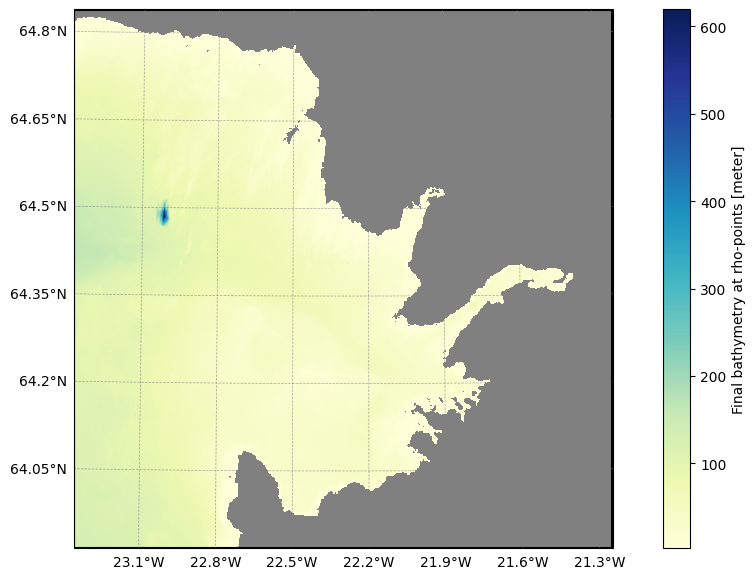

In [41]:
grid.plot()

In [42]:
filepath = project+model_name+'_grid.nc'

In [43]:
grid.update_vertical_coordinate(N=60, theta_s=5.0, theta_b=5.0, hc=5.0, verbose=False)

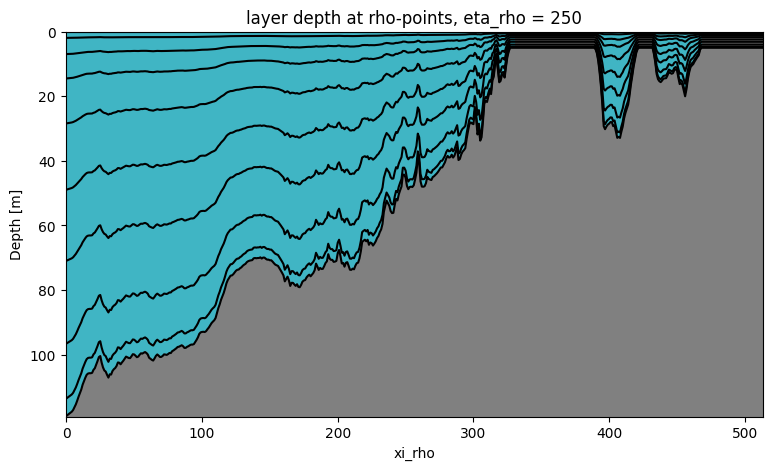

In [44]:
grid.plot_vertical_coordinate(eta=250, max_nr_layer_contours=10,)

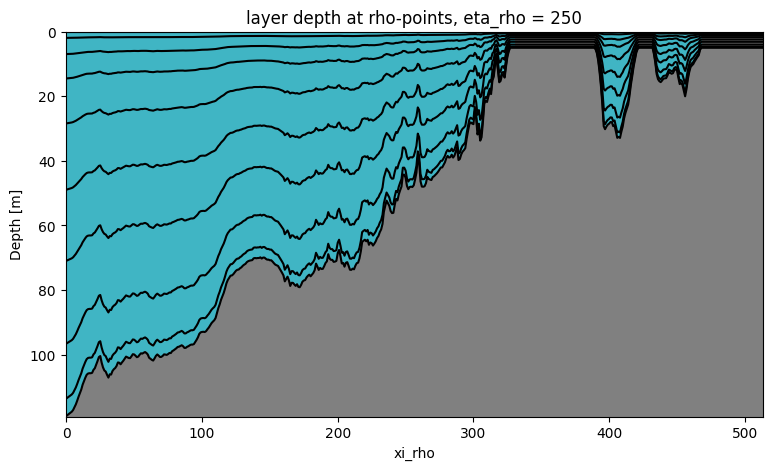

In [45]:
grid.plot_vertical_coordinate(eta=250, max_nr_layer_contours=10,)

In [46]:
grid.save(filepath)

2025-11-20 17:30:27 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_grid.nc


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_grid.nc')]

In [47]:
tpxo_path = datasets+"TPXO/TPXO10.v2/"
tpxo_dict = {
    "grid": tpxo_path + "grid_tpxo10v2.nc",
    "h": tpxo_path + "h_tpxo10.v2.nc",
    "u": tpxo_path + "u_tpxo10.v2.nc",
}

Next, we set up tidal forcing:

In [48]:
from roms_tools import TidalForcing

In [49]:
from datetime import datetime

In [50]:
model_reference_date = datetime(2000, 1, 1)

In [51]:

tidal_forcing = TidalForcing(
    grid=grid,
    source={"name": "TPXO", "path": tpxo_dict},
    ntides=15,  # Number of constituents to consider <= 15. Default is 10.
    model_reference_date=model_reference_date,  # Model reference date. Default is January 1, 2000.
    use_dask=True
)

2025-11-20 17:30:31 - INFO - Applying 2D horizontal fill to the source data before regridding.
2025-11-20 17:30:31 - INFO - Applying 2D horizontal fill to the source data before regridding.
2025-11-20 17:30:31 - INFO - Applying 2D horizontal fill to the source data before regridding.
2025-11-20 17:30:31 - INFO - Applying 2D horizontal fill to the source data before regridding.


In [52]:
filepath = project+model_name+"_tides.nc"

In [53]:
%time tidal_forcing.save(filepath)

2025-11-20 17:30:32 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_tides.nc


[########################################] | 100% Completed | 2.06 sms
CPU times: user 4.09 s, sys: 975 ms, total: 5.06 s
Wall time: 2.17 s


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_tides.nc')]

For the surface forcing, we use ERA5 plus the unified BGC dataset

In [54]:
from roms_tools import Grid, SurfaceForcing

In [55]:
start_time = datetime(2024, 7, 1)
end_time = datetime(2024, 12, 31)

In [56]:
surface_forcing_kwargs = {
    "grid": grid,
    "start_time": start_time,
    "end_time": end_time,
    "type": "physics",
    "model_reference_date": datetime(2000, 1, 1), # this is the default
}

In [57]:
%%time

surface_forcing = SurfaceForcing(
    **surface_forcing_kwargs,
    source={"name": "ERA5"},
    use_dask=True,
)

2025-11-20 17:30:34 - INFO - No path specified for ERA5 source; defaulting to ARCO ERA5 dataset on Google Cloud.
2025-11-20 17:32:19 - INFO - Data will be interpolated onto the grid coarsened by factor 2. Remember to set `interp_frc = 1` in your `bulk_frc.opt` ROMS option file.
2025-11-20 17:32:19 - INFO - Applying 2D horizontal fill to the source data before regridding.
2025-11-20 17:32:22 - INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 2min 37s, sys: 9.44 s, total: 2min 46s
Wall time: 2min 49s


[########################################] | 100% Completed | 101.63 ms


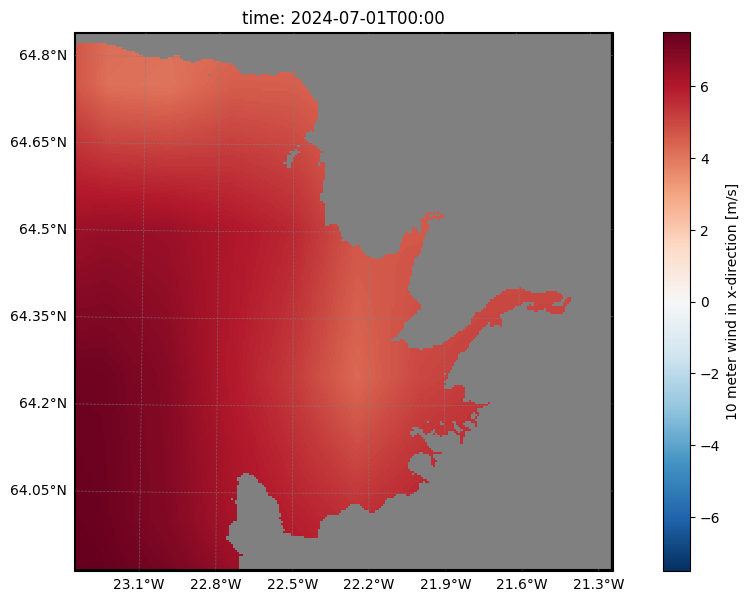

In [58]:
surface_forcing.plot("uwnd", time=0)

In [59]:
#cesm_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-surface_lowres_regridded.nc"
unified_bgc_path = datasets+"UNIFIED/BGCdataset.nc"

In [60]:
%%time

unified_bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "UNIFIED", "path": unified_bgc_path, "climatology": True},
    type="bgc",
    use_dask=True,
)

2025-11-20 17:33:27 - INFO - Data will be interpolated onto the grid coarsened by factor 2. Remember to set `interp_frc = 1` in your `bgc.opt` ROMS option file.
2025-11-20 17:33:27 - INFO - 2D horizontal fill is skipped because source data already contains filled values.


CPU times: user 142 ms, sys: 3.95 ms, total: 146 ms
Wall time: 607 ms


In [61]:
filepath = project+model_name+"_surface_forcing2024.nc"

In [62]:
%time surface_forcing.save(filepath, group=True)

2025-11-20 17:33:30 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202407.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202408.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202409.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202410.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202411.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202412.nc


[########################################] | 100% Completed | 78.50 s
[########################################] | 100% Completed | 81.07 s
[########################################] | 100% Completed | 77.07 s
[########################################] | 100% Completed | 82.19 s
[########################################] | 100% Completed | 81.61 s
[########################################] | 100% Completed | 77.83 s
CPU times: user 13min 29s, sys: 2min 10s, total: 15min 39s
Wall time: 9min 17s


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202407.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202408.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202409.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202410.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202411.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_surface_forcing2024_202412.nc')]

In [63]:
filepath = project+model_name+"_bgc_surface_forcing.nc"

In [64]:
%time unified_bgc_surface_forcing.save(filepath)

2025-11-20 17:42:44 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_bgc_surface_forcing_clim.nc


[########################################] | 100% Completed | 407.33 ms
CPU times: user 212 ms, sys: 23.8 ms, total: 236 ms
Wall time: 446 ms


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_bgc_surface_forcing_clim.nc')]

Next we generate the initial file

In [65]:
from roms_tools import Grid, ChildGrid

In [66]:
parent_grid = grid

In [67]:
child_grid_parameters = {
    "nx": 512,
    "ny": 512,
    "size_x": 102.4/4,
    "size_y": 102.4/4,
    "center_lon": -21.75,
    "center_lat": 64.3,
    "rot": 0,
    "topography_source": {
        "name": "SRTM15",
        "path": datasets+"SRTM15/SRTM15_V2.6.nc"},
    "N":40  # number of vertical layers
}

In [68]:
child_grid = ChildGrid(
    **child_grid_parameters,
    parent_grid=parent_grid,
    boundaries={
        "south": True,
        "east": False,
        "north": False,
        "west": True,
    },  # this is the default
    metadata={"prefix": "child", "period": 1800.0}  # this is the default
)

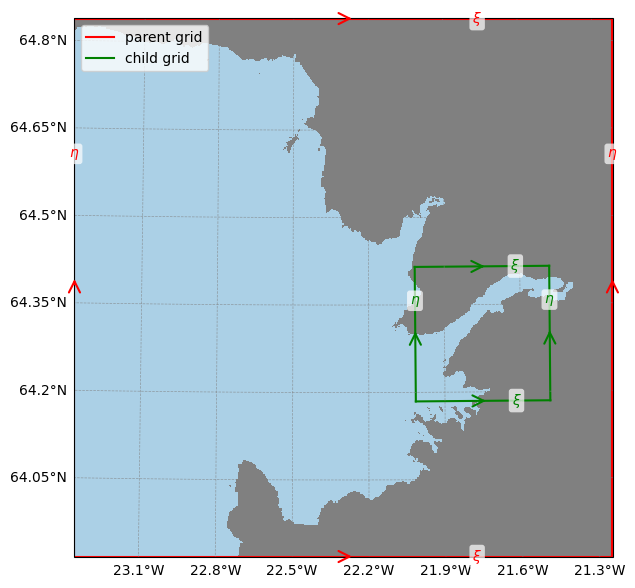

In [69]:
child_grid.plot_nesting(with_dim_names=True)

In [70]:
filepath = project+child_name+"_grid.nc"
child_grid.save(filepath=filepath)

2025-11-20 17:45:25 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland3_grid.nc


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland3_grid.nc')]

In [71]:
filepath_nesting = project+child_name+"_edata.nc"

In [72]:
child_grid.save_nesting(filepath=filepath_nesting)

2025-11-20 17:45:25 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland3_edata.nc


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland3_edata.nc')]

In [73]:
import xarray as xr

In [74]:
from roms_tools import RiverForcing, Grid

In [75]:
from datetime import datetime

In [77]:
riv0=xr.open_dataset('/anvil/projects/x-ees250129/Datasets/Iceland_river_dataset/Hvalfjordur_rivers_2023.nc')

In [78]:
riv0['time']=[202401., 202402., 202403., 202404., 202405., 202406., 202407., 202408.,
       202409., 202410., 202411., 202412.]

In [80]:
riv0.to_netcdf('/anvil/projects/x-ees250129/Datasets/Iceland_river_dataset/Hvalfjordur_rivers_2024.nc')

In [81]:
start_time = datetime(2024, 1, 1)
end_time = datetime(2024, 12, 31)

In [82]:
river_forcing = RiverForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    model_reference_date=datetime(2000, 1, 1), # this is the default
    include_bgc=True,
    source = {
    "name": "DAI",
    "path": "/anvil/projects/x-ees250129/Datasets/Iceland_river_dataset/Hvalfjordur_rivers_2024.nc",
    "climatology": False
}
    
)

2025-11-20 17:55:33 - INFO - No river indices provided. Identify all rivers within the ROMS domain and assign each of them to the nearest coastal point.
2025-11-20 17:55:33 - WARNING - No records found at or before the start_time.
2025-11-20 17:55:33 - WARNING - No records found at or after the end_time.
2025-11-20 17:55:33 - INFO - Creating 1 synthetic river(s) to handle overlapping entries.


In [83]:
river_forcing.ds

<xarray.Dataset> Size: 2MB
Dimensions:           (nriver: 15, river_time: 12, ntracers: 34, eta_rho: 514,
                       xi_rho: 514)
Coordinates:
    river_name        (nriver) object 120B 'HVAL1' 'HVAL2' ... 'overlap_1'
  * nriver            (nriver) int64 120B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    abs_time          (river_time) datetime64[ns] 96B 2024-01-15 ... 2024-12-15
  * river_time        (river_time) float64 96B 8.78e+03 8.811e+03 ... 9.115e+03
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
Dimensions without coordinates: ntracers, eta_rho, xi_rho
Data variables:
    river_volume      (river_time, nriver) float64 1kB 0.09365 0.1489 ... 1.691
    river_tracer      (river_time, ntracers, nriver) float64 49kB 17.0 ... 1....
    river_index       (eta_rho, xi_rho) float32 1MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    river_fraction    (eta_rho, xi_rho) float32 1MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

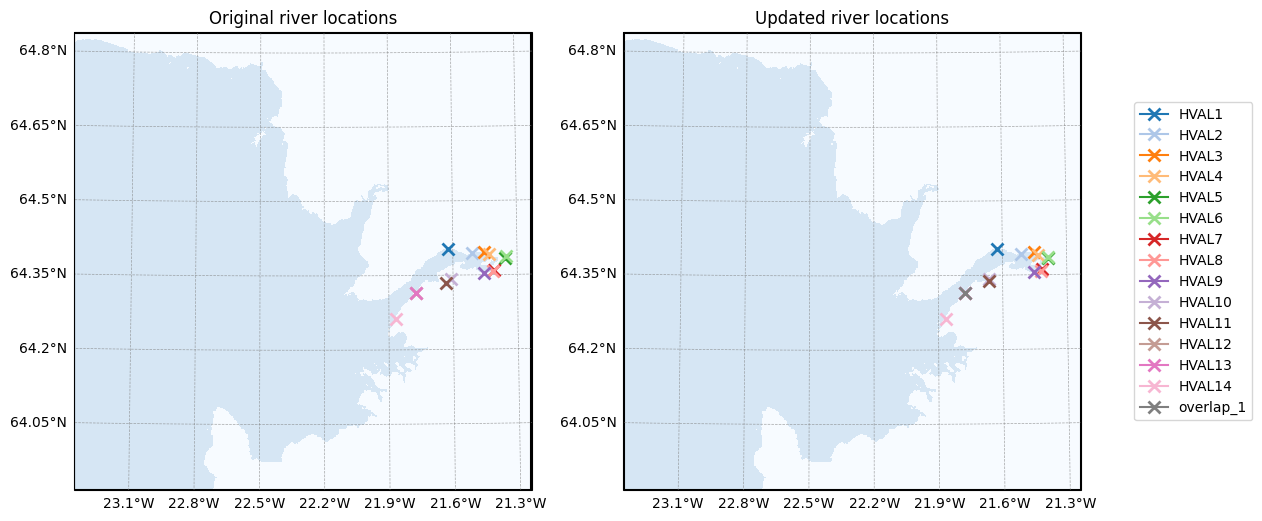

In [84]:
river_forcing.plot_locations()

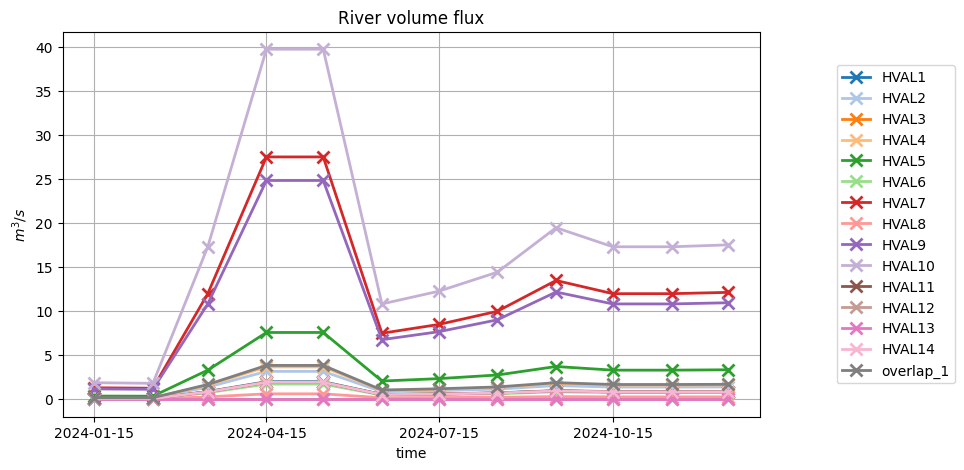

In [85]:
river_forcing.plot("river_volume")

In [86]:
filepath = project+model_name+"_rivers.nc"

In [87]:
river_forcing.save(filepath=filepath)

2025-11-20 17:55:44 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_rivers.nc


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland2_MARBL_2024_NewV/Iceland2_rivers.nc')]

Making some customizations to the river forcing (we have observed values of alk and DIC in the rivers and we also know the water is not going to be 17 degrees warm!). We add nutrients (observed values in fjord before spring bloom) and we add observed riverine values of Alk and DIC. These should be subject to change.

In [88]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
riv=xr.open_dataset(filepath)
riv.load()

/tmp/ipykernel_3614130/3130065273.py:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  riv=xr.open_dataset(filepath)


<xarray.Dataset> Size: 2MB
Dimensions:           (river_time: 12, nriver: 15, ntracers: 34, eta_rho: 514,
                       xi_rho: 514)
Coordinates:
    river_name        (nriver) object 120B 'HVAL1' 'HVAL2' ... 'overlap_1'
  * nriver            (nriver) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    abs_time          (river_time) datetime64[ns] 96B 2024-01-15 ... 2024-12-15
  * river_time        (river_time) timedelta64[ns] 96B 8780 days ... 9115 days
    tracer_name       (ntracers) object 272B 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) object 272B 'degrees Celsius' ... 'mmol/m^3'
    tracer_long_name  (ntracers) object 272B 'potential temperature' ... 'dia...
Dimensions without coordinates: ntracers, eta_rho, xi_rho
Data variables:
    river_volume      (river_time, nriver) float64 1kB 0.09365 0.1489 ... 1.691
    river_tracer      (river_time, ntracers, nriver) float64 49kB 17.0 ... 1....
    river_index       (eta_rho, xi_rho) float32 1MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    river_fraction    (eta_rho, xi_rho) float32 1MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [ ]:
#riv['river_time']=pd.to_datetime(['2024-01-15T00:00:00.000000000', '2024-02-15T00:00:00.000000000',
#       '2024-03-15T00:00:00.000000000', '2024-04-15T00:00:00.000000000',
#       '2024-05-15T00:00:00.000000000', '2024-06-15T00:00:00.000000000',
#       '2024-07-15T00:00:00.000000000', '2024-08-15T00:00:00.000000000',
#       '2024-09-15T00:00:00.000000000', '2024-10-15T00:00:00.000000000',
#       '2024-11-15T00:00:00.000000000', '2024-12-15T00:00:00.000000000'])


In [89]:
riv['river_time']

<xarray.DataArray 'river_time' (river_time: 12)> Size: 96B
array([758592000000000000, 761270400000000000, 763776000000000000,
       766454400000000000, 769046400000000000, 771724800000000000,
       774316800000000000, 776995200000000000, 779673600000000000,
       782265600000000000, 784944000000000000, 787536000000000000],
      dtype='timedelta64[ns]')
Coordinates:
    abs_time    (river_time) datetime64[ns] 96B 2024-01-15 ... 2024-12-15
  * river_time  (river_time) timedelta64[ns] 96B 8780 days ... 9115 days
Attributes:
    long_name:  relative time: days since 2000-01-01 00:00:00

In [90]:
riv['tracer_name']

<xarray.DataArray 'tracer_name' (ntracers: 34)> Size: 272B
array(['temp', 'salt', 'PO4', 'NO3', 'SiO3', 'NH4', 'Fe', 'Lig', 'O2',
       'DIC', 'DIC_ALT_CO2', 'ALK', 'ALK_ALT_CO2', 'DOC', 'DON', 'DOP',
       'DOPr', 'DONr', 'DOCr', 'zooC', 'spChl', 'spC', 'spP', 'spFe',
       'spCaCO3', 'diatChl', 'diatC', 'diatP', 'diatFe', 'diatSi',
       'diazChl', 'diazC', 'diazP', 'diazFe'], dtype=object)
Coordinates:
    tracer_name       (ntracers) object 272B 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) object 272B 'degrees Celsius' ... 'mmol/m^3'
    tracer_long_name  (ntracers) object 272B 'potential temperature' ... 'dia...
Dimensions without coordinates: ntracers
Attributes:
    long_name:  Tracer name

In [91]:
# Create new array
new_tracer = np.zeros_like(riv['river_tracer'].values)

# Temperature varies sinusoidally with time
temp = 10 * np.sin(np.linspace(0, np.pi, riv.dims['river_time']))  # 12-month cycle

# Loop through tracers
for i, tracer in enumerate(riv['tracer_name'].values):
    if tracer == 'temp':
        new_tracer[:, i, :] = temp[:, np.newaxis]  # vary with time
    elif tracer == 'salt':
        new_tracer[:, i, :] = 1
    elif tracer == 'PO4':
        new_tracer[:, i, :] = 0.4
    elif tracer == 'NO3':
        new_tracer[:, i, :] = 6
    elif tracer == 'SiO3':
        new_tracer[:, i, :] = 3
    elif tracer == 'NH4':
        new_tracer[:, i, :] = 0.4
    elif tracer == 'Fe':
        new_tracer[:, i, :] = 0.000197
    elif tracer == 'Lig':
        new_tracer[:, i, :] = 0.000465    
    elif tracer == 'O2':
        new_tracer[:, i, :] = 360    
    elif tracer == 'DIC':
        new_tracer[:, i, :] = 313    
    elif tracer == 'DIC_ALT_CO2':
        new_tracer[:, i, :] = 313  
    elif tracer == 'ALK':
        new_tracer[:, i, :] = 282 
    elif tracer == 'ALK_ALT_CO2':
        new_tracer[:, i, :] = 282 
    else:
        new_tracer[:, i, :] = 0.0
riv['river_tracer'] = (riv['river_tracer'].dims, new_tracer)

/tmp/ipykernel_3614130/608848569.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  temp = 10 * np.sin(np.linspace(0, np.pi, riv.dims['river_time']))  # 12-month cycle


In [92]:
updated_tracer_values=[10,1,0.4,6,3,0.4,0.000197,0.000465,360,313,313,282,282,14,1.18,0.05,0.0257,1.35,26,0.260,0.0442,0.02,0.000171,0.0000004,0.00056,0.0143,0.044,0.000375,0.0000004,0.019,0.0001225,0.001,0.00000066,0.000000046]

In [ ]:
plt.plot(temp)

In [93]:
riv.to_netcdf(project+model_name+"_rivers_modified.nc")

In [ ]:
import xarray as xr

# Open your modified file
river = xr.open_dataset(project+model_name+"_rivers_modified.nc")
river.load()
# Show what tracers exist
river['river_tracer'].isel(ntracers=10).isel(nriver=6).plot()



In [ ]:
riv

Now, we make another river forcing file with half as much volume

In [ ]:
riv['river_volume']= riv['river_volume']*0.5

In [ ]:
riv.to_netcdf(project+model_name+"_rivers_modified_HALF.nc")

In [ ]:
import xarray as xr

# Open your modified file
river1 = xr.open_dataset(project+model_name+"_rivers_modified.nc")
river1.load()
# Show what tracers exist
river1['river_volume'].isel(nriver=6).plot()


In [ ]:
import xarray as xr

# Open your modified file
river2 = xr.open_dataset(project+model_name+"_rivers_modified_HALF.nc")
river2.load()
# Show what tracers exist
river2['river_volume'].isel(nriver=0).plot()

In [ ]:
project+model_name+"_rivers_modified_HALF.nc

In [ ]:
project+model_name